In [101]:
import numpy as np
import pandas as pd
from pandas import read_csv
import sys
import time
import math
import random
from sklearn.ensemble import RandomForestRegressor
import graphviz
import matplotlib.pyplot as plt
print("success")

success


# Function which can compared the last two colunm for Accuracy, Precision, Recall, F-score

In [102]:
def cor_percentage(pred,actual,B2=1):   #input should be pd.series
    try:
        # solve the problem caused by transer to series from array
        pred=pd.Series(pred.tolist())
        actual=pd.Series(actual.tolist())
        # get the row of row number of dataframe
        df_row_num=len(actual)

        # get the accuracy
        pred_actual=abs(pred-actual)
        same_num=df_row_num-sum(pred_actual)
        accur=same_num/df_row_num

        pred_sum=sum(pred)
        actual_sum=sum(actual)
        
        # get the Precision and recall
        same1_count=0
        # correct=0
#         print(pred_sum)
#         print(actual_sum)
        
        add_list=np.array(pred+actual)
        same1_count=len(add_list[add_list > 1])

        precision=(same1_count)/(pred_sum)
        recall=(same1_count)/(actual_sum)

        F_score=((1+B2)*precision*recall)/(recall+precision*B2)

    #     print(accur,end=" ")
    #     print(precision,end=" ")
    #     print(recall,end=" ")
    #     print(F_score)
        #return the result
        return accur,precision,recall,F_score
    except:
        return 0,0,0,0

def loss(y, yp):
    return (-y * np.log(yp) - (1 - y) * np.log(1 - yp)).mean()

# Get the data from the csv

In [103]:
train = read_csv('training.csv')
train = train.dropna(axis=0)
train

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,high,low,5more,2,med,med,unacc
1,med,low,5more,4,small,low,unacc
2,med,med,4,more,med,low,unacc
3,low,med,3,more,med,low,unacc
4,low,vhigh,3,more,big,low,unacc
...,...,...,...,...,...,...,...
1110,med,vhigh,5more,more,small,low,unacc
1111,vhigh,high,4,4,big,med,unacc
1112,vhigh,high,3,more,med,low,unacc
1113,med,med,4,2,big,med,unacc


In [104]:
train.describe()

,buying,maint,doors,persons,lug_boot,safety,evaluation
count,1115,1115,1115,1115,1115,1115,1115
unique,4,4,4,3,3,3,2
top,high,vhigh,2,2,small,low,unacc
freq,308,301,298,387,382,408,846


In [105]:
test = read_csv('test.csv')
test = test.dropna(axis=0)
test

,buying,maint,doors,persons,lug_boot,safety
0,low,vhigh,3,more,med,med
1,vhigh,high,2,more,small,high
2,vhigh,med,5more,4,med,high
3,med,med,5more,4,small,med
4,high,med,4,4,small,high
...,...,...,...,...,...,...
474,low,vhigh,4,4,big,high
475,med,vhigh,3,more,big,high
476,vhigh,low,3,4,big,high
477,med,vhigh,2,2,med,med


In [106]:
test.describe()

,buying,maint,doors,persons,lug_boot,safety
count,479,479,479,479,479,479
unique,4,4,4,3,3,3
top,vhigh,high,5more,2,small,low
freq,132,132,130,189,173,168


# Data preprocessing

Make the data from string to variable, which is more convient for us to process the data

In [107]:
# 7. Attribute Values:

#    buying       v-high, high, med, low
#    maint        v-high, high, med, low
#    doors        2, 3, 4, 5-more
#    persons      2, 4, more
#    lug_boot     small, med, big
#    safety       low, med, high

# {'high', 'low', 'med', 'vhigh'}
# {'high', 'med', 'low', 'vhigh'}
# {'4', '3', '2', '5more'}
# {'4', 'more', '2'}
# {'med', 'big', 'small'}
# {'high', 'low', 'med'}
# {'unacc', 'acc'}

# Data preprocessing
def classify(x, cls):
        return list(cls).index(x)
def preprocess(df, proportion=.8, if_seperate=True):
    rows=df.shape[0]
    col = df.columns.values.tolist()
    # mix the number sequence of rows
    index_list=list(range(rows))
    np.random.shuffle(index_list)
    
#     # store the random line
    mix_df = df.iloc[index_list]
    #print(mix_df)
    # get the unique coloums
    ucs=[]
    
    buying=['low','med','high','vhigh']
    maint=['low','med','high','vhigh']
    doors=['2','3','4','5more']
    persons=['2','4','more']
    lug_boot=['small','med', 'big']
    safety=['low','med','high' ]
    evaluation=['unacc', 'acc']
    list_col=[buying,maint,doors,persons,lug_boot,safety,evaluation]
    
    for each in list_col:
        ucs.append(each)
    # replace all the df to number
    coloums=0
    for c in col:
        # get the unique of the colounm for replace them to number
        uc = ucs[coloums]
        #print(ucs)
#         print(ucls)
        mix_df[c] = mix_df[c].apply(lambda x: classify(x, uc))
        coloums+=1
        
    p_train = int(np.floor(rows * proportion))
    train = mix_df.iloc[:p_train]
    test = mix_df.iloc[p_train:]
    if if_seperate:
        return train, test
    else:
        return mix_df
# separate the dataframe into 4 pieces
def separate_df(df, proportion=.8):
    training, testing=preprocess(df, proportion, True)
    train_x=training.iloc[:,:-1]
    train_y=training.iloc[:,-1]
    test_x=testing.iloc[:,:-1]
    test_y=testing.iloc[:,-1]
    return train_x,train_y,test_x,test_y

# reverse the unacc and acc
def separate_df_reverse(df, proportion=.8):
    train_x,train_y,test_x,test_y=separate_df(df, proportion=.8)
    train_y_n=-1*train_y
    test_y_n=-1*test_y
    return train_x,train_y_n,test_x,test_y_n

# restore the orginal data
def restore(rev):
    buying=['low','med','high','vhigh']
    maint=['low','med','high','vhigh']
    doors=['2','3','4','5more']
    persons=['2','4','more']
    lug_boot=['small','med', 'big']
    safety=['low','med','high' ]
    evaluation=['unacc', 'acc']
    predict=['unacc', 'acc']
    list_col=list(rev)
    for coll in list_col:
        true_var=eval(coll)
        list_num=list(range(len(true_var)))
#         print(list_num)
#         print(true_var)
        rev[coll]=rev[coll].replace(list_num,true_var)
    return rev
    

In [108]:
# sperate the result
tmp_train1=train
tmp_test1=test
preprocess(train, .8,True)
tmp_train,tmp_test=preprocess(tmp_train1, .8,True)
temp_mix_df=preprocess(tmp_train1, .8,False)
train_x,train_y,test_x,test_y=separate_df(train)

In [109]:
tmp_train

,buying,maint,doors,persons,lug_boot,safety,evaluation
259,0,0,0,2,1,1,1
250,2,3,2,2,1,2,0
101,0,0,0,0,2,1,0
342,1,2,0,2,2,1,1
513,2,1,3,2,0,2,1
...,...,...,...,...,...,...,...
26,3,3,2,1,0,1,0
514,0,0,0,0,1,2,0
929,1,3,1,0,2,0,0
724,3,1,0,0,2,1,0


In [110]:
tmp_test

,buying,maint,doors,persons,lug_boot,safety,evaluation
804,0,1,3,0,0,1,0
246,2,3,2,2,0,2,0
658,1,2,1,1,1,0,0
649,0,3,0,0,2,1,0
734,2,3,3,0,0,2,0
...,...,...,...,...,...,...,...
213,0,3,1,1,1,1,0
994,3,2,2,1,2,2,0
27,0,2,1,1,1,1,1
192,1,0,2,0,2,1,0


In [111]:
temp_mix_df

,buying,maint,doors,persons,lug_boot,safety,evaluation
719,0,2,2,1,0,1,1
289,0,2,0,0,1,1,0
788,0,3,2,0,2,0,0
494,3,1,1,0,0,0,0
781,3,3,3,0,2,0,0
...,...,...,...,...,...,...,...
1000,0,1,2,0,0,2,0
414,1,0,1,1,2,0,0
602,2,2,1,1,1,1,0
32,0,3,1,0,2,2,0


In [112]:
train_x

,buying,maint,doors,persons,lug_boot,safety
595,3,0,0,2,2,1
298,2,0,1,0,0,0
134,2,1,1,0,1,0
957,0,2,0,1,1,1
559,1,2,1,1,1,1
...,...,...,...,...,...,...
342,1,2,0,2,2,1
261,3,3,2,1,2,0
1043,0,2,3,2,1,0
1008,3,0,1,1,1,2


In [113]:
train_y

595     1
298     0
134     0
957     1
559     0
       ..
342     1
261     0
1043    0
1008    1
706     0
Name: evaluation, Length: 892, dtype: int64

In [114]:
test_x

,buying,maint,doors,persons,lug_boot,safety
27,0,2,1,1,1,1
424,2,1,0,0,1,0
901,2,0,3,2,1,0
255,2,3,0,2,0,2
1027,1,2,3,0,2,1
...,...,...,...,...,...,...
734,2,3,3,0,0,2
116,1,3,3,0,2,0
141,0,3,1,2,0,0
35,1,0,3,0,1,0


In [115]:
test_y

27      1
424     0
901     0
255     0
1027    0
       ..
734     0
116     0
141     0
35      0
897     0
Name: evaluation, Length: 223, dtype: int64

# Knn for a certain k

In [18]:
# KNN for certain k
def judge_knn(train_x,train_y,test_x,test_y,k):
    finial_list=[]
    test_x_height=test_x.shape[0]
    for i in range(test_x_height):
        
        # sub the i line and take abs for the dataframe
        
        # euclidean distance
        abs_subp=abs(train_x-test_x.iloc[i])
        #sum by line
        distance_list=((abs_subp != 0).astype(int).sum(axis=1))
    
    
        #store the distance and the result into result df
        result_df=pd.concat([distance_list,train_y],axis=1)
        # change the dataframe to array
        result_list=result_df.values
        
        # return the min distance with it result
        closest=result_list[sorted(np.argsort(result_list.T[0])[:k])]
        counts = np.bincount(closest[0])
        
        #get the counts max result
        type_w = np.argmax(counts)                                       
        
        # put the result for the pridiction line
        finial_list.append(type_w)
    
    pr=test_x.assign(evaluation=pd.Series(test_y).values)
    # insert all the result into the predict dataframe
    pr2 = pr.assign(predict=pd.Series(finial_list).values)
    return pr2

1
0.6429065540589503
2
0.6229255704144316
3
0.6525913922192544
4
0.6537896169638107
5
0.656516022211061
6
0.6304472998945807
7
0.6131947167308018
8
0.6020091702753172
9
0.6064522329669859
10
0.5936839458735078


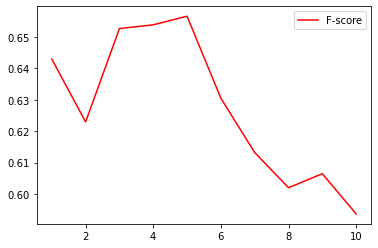

[5, 0.656516022211061]


In [19]:
# finding the k
bestk=1
best_correctness=0
times=11
test_list=[]
# use for to test the k  one by one
for k in range(1,times):
    k_correctness = 0
    tmp_correctness=[]
    for i in range(10):
        
        train_x,train_y,test_x,test_y=separate_df(train)
        
        df=judge_knn(train_x,train_y,test_x,test_y,k)

        # predict colounm
        pred=df.iloc[:,-1]
        # actual colounm
        actual=df.iloc[:,-2]

        tmp_correctness.append(cor_percentage(pred,actual)[3])
    
    s_tmp=sum(tmp_correctness)/(times-1)
    if(s_tmp>k_correctness):
        k_correctness=s_tmp
        
    print(k)
    print(k_correctness)
    
    test_list.append(s_tmp)
    
    if k_correctness > best_correctness:
        bestk=k
        best_correctness=k_correctness
    
    
plt.plot(range(1,times),test_list,color="red",label="F-score") 
plt.legend()
plt.show()

print([bestk,best_correctness])

In [20]:
# just change the k
k=3
        
#KNN
train_x,train_y,test_x,test_y=separate_df(tmp_train1)

start = time.time()
df1=judge_knn(train_x,train_y,test_x,test_y,k)
end = time.time()
print ("Total running time: "+str(end-start)+"s")

# # predict colounm
# pred=df.iloc[:,-1]
# # actual colounm
# actual=df.iloc[:,-2]

# correctness = cor_percentage(pred,actual)
# print(correctness)
# for i in df.iloc[:,-1]:
#     print(i)
# df1
hi=restore(df1)
hi


Total running time: 0.9680733680725098s


,buying,maint,doors,persons,lug_boot,safety,evaluation,predict
629,vhigh,high,2,4,big,med,unacc,unacc
282,vhigh,med,2,more,small,low,unacc,unacc
198,low,vhigh,2,4,med,low,unacc,unacc
560,high,low,5more,2,small,med,unacc,unacc
227,low,low,4,4,med,low,unacc,unacc
...,...,...,...,...,...,...,...,...
1036,med,med,4,4,small,med,acc,acc
48,high,med,5more,2,small,low,unacc,unacc
451,med,med,2,more,med,low,unacc,unacc
986,low,high,3,2,med,med,unacc,unacc


# Naïve Bayes

In [40]:
def Naive_Bayes(predict_frame,train_frame):
    tf=train_frame
    pf=predict_frame

    # get the column name
    col_pf_name=pf.columns.values.tolist()
    col_tf_name=tf.columns.values.tolist()
    
    
    # check whether two dafaframe are input correctly
    if col_pf_name==col_tf_name:
        col_pf_name=col_pf_name[:-1]
    elif col_pf_name!=col_tf_name[:-1]:
        print("Two dataframe are not fit")
        sys.exit()
    
    # get the set of last column, which is the type of result
    result_type=list(set(tf[col_tf_name[-1]]))
    
    # get the result of each precentage
    Pre_result=[]
    # seperate the dataframe by the result, and store them into list
    tf_list_by_type=[]
    
    for type_R in result_type:
        # the temp_list is used for isin function, isin can only accept list type function
        temp_list=[]
        temp_list.append(type_R)
        # append the dataframe according to the type of result, the order is same as result type
        temp_df=tf[tf[col_tf_name[-1]].isin(temp_list)]
        tf_list_by_type.append(temp_df)
        
        # append the precentage of different type of result
        temp_P=(temp_df.shape[0])/(tf.shape[0])
        Pre_result.append(temp_P)
        
    
#     # test whether the dataframe or percentage result can be seperated by result
#     for i in Pre_result:
#         print(i)
    
#     sys.exit()
    
    
    #stop_count=0   # test variable
    
    #pridiction result list
    result_list=[]
    # read the predictframe line by line
    for index,row in pf.iterrows():
        #store all the happen presentage under dirrerent result
        P_result=[]
        for count_df in range(len(tf_list_by_type)):
            # store the dadaframe cuttenly used
            subtf = tf_list_by_type[count_df]
            # get the subtrainingframe length of column
            subtf_len=subtf.shape[0]
            
            #for get the percentage
            temp=1
            # get each attribute
            for attr_name in col_tf_name[:-1]:
                temp_list=[]    # this is also fot isin
                #print(row[attr],end=" ")
                attr=row[attr_name]
                temp_list.append(attr)
                # mult the similarity percentage to temp
                temp*=(len(subtf[subtf[attr_name].isin(temp_list)])/subtf_len)
            
            # append the precentage of the result
            P_result.append(temp*Pre_result[count_df])
        
        # judge the result of that line according to the biggest result
        max_index=P_result.index(max(P_result))
        result_list.append(result_type[max_index])

#         stop_count+=1   # test variable
#         if stop_count>4:
#             sys.exit()
    pf2 = pf.assign(predict=pd.Series(result_list).values)
    return pf2

In [22]:
# Naïve Bayes
tf=tmp_train
pf=tmp_test
start=time.time()
df=Naive_Bayes(pf,tf)
end = time.time()
print ("Total running time: "+str(end-start)+"s")
df

Total running time: 1.6250066757202148s


,buying,maint,doors,persons,lug_boot,safety,evaluation,predict
423,2,2,3,0,2,0,0,0
1011,3,3,0,0,0,0,0,0
86,2,0,3,1,2,1,1,1
242,3,1,1,0,2,0,0,0
252,1,2,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1090,0,2,0,2,0,1,0,1
333,2,0,2,2,2,1,1,1
825,2,1,2,1,1,2,1,1
1087,0,3,0,0,2,0,0,0


In [23]:
tmp_train,tmp_test=preprocess(tmp_train1, .8,True)

# Naïve Bayes
tf=tmp_train
pf=tmp_test
#Naive_Bayes(pf,tf)
df=Naive_Bayes(pf,tf)

# predict colounm
pred=df.iloc[:,-1]
# actual colounm
actual=df.iloc[:,-2]
    
cor_percentage(pred,actual)

(0.8475336322869955, 0.6304347826086957, 1.0, 0.7733333333333333)

# Perceptron

In [89]:
# ANN
# each funtion update the w for each time, just use a line of data to modify the w
def update_wnew(w,I,T,learning_rate):
    #initial value which store the wnew and the sum of weight
    wnew=[]
    
    #get teh sum of weight
    suming=weight_sum(w,I)
    # return the activate fuction 
    # make the perparation for the change of w
    O1=activate_func(suming)
    
    distance=T-O1
    if(distance!=0):
        #print(I)
        #print(w)
        add_sum=np.array(I)*learning_rate*distance
        tmp=add_sum+np.array(w)
        wnew=tmp.tolist()
        #print(wnew)
        #print(distance,wnew)
        return distance,wnew
    else:
        #print(distance,w)
        return 0,w

def singleANN(tf,learning_rate):
    # w_initial=[0,0,0]
    tc=tf.columns
    w=(np.zeros(len(tc))).tolist()
    
    list_I,list_T=transfer(tf)
    
    time=0     #recording test variable
    
    sign_stay=1
    # if w is changing during the process of reading all the data, it will stay process until it become unchange
    while(sign_stay==1):
        
        distance_list=np.empty(shape=0)
        sign_stay=1
        time+=1
        
        # for every single data in the list_T, check if the w meet the requirement
        for i in range(len(list_T)):
            # for one line
            dis,w=update_wnew(w,list_I[i],list_T[i],learning_rate)
            # check the value of w################################
            #print(w)
            #calculate the loss
            ########################################
            #dis_process=abs(dis)
            #distance_list=np.append(distance_list,dis_process)
        
#         print(time)
#         print(distance_list.var())
#         print(distance_list.mean())
        ##########################################
        
#         if(time>50):
#             print(w)
        if(time>100):
            break
            
    return w

# return the weight_sum
def weight_sum(w,I):
    # get the weight sum
    suming=0
    # sum all the w according to then length of I(w)
    for i in range(len(w)):
        suming+=w[i]*I[i]
    return suming

# return the result of activate function
def activate_func(weight_s):
    #step function
    if weight_s>=0:
        return 1
    else:
        return 0
# return the dataframe according to w
def get_predict(w,pred):
    df_without=pred.iloc[:,:-1]
    df_label=pred.iloc[:,-1]
    df_without['bias']=np.ones(df_without.shape[0])
    
    # get the output
#     print(w)
#     print(df_without)
    
    mult_df_w=np.array(w)*df_without
    
#     display(mult_df_w)
    
    sum_weight=mult_df_w.sum(axis=1)
    
#     display(sum_weight)
    #print("true")
    #display(df_label)
    
    result_list=[]
    #use activate to see it
    for i in range(len(sum_weight)):
       #print(sum_weight.iloc[i])
        result=activate_func(sum_weight.iloc[i])
        
        result_list.append(result)
    
    #display(result_list)
    df_plus=pred.assign(predict=pd.Series(result_list).values)
    return df_plus
    
# change the dataframe into the list_I and list_T
def transfer(tf):
    # list_T=[0,0,1,1,0,1]
    # list_I=[[1,5,1],[1,2,1],[1,1,1],[1,3,3],[1,4,2],[1,2,3]]
    
    list_I=tf.iloc[:,:-1]
    list_I['bias']=np.ones(tf.shape[0])
    list_I=(list_I.values).tolist()
    list_T=tf.iloc[:,-1].tolist()
    
    return list_I,list_T

In [92]:
# input
tmp_train,tmp_test=preprocess(tmp_train1, .8,True)
tf=tmp_train
pf=tmp_test
learning_rate=0.05

start = time.time()
w=singleANN(tf,learning_rate)
end = time.time()
print ("Total running time: "+str(end-start)+"s")

df=get_predict(w,pf)

# predict colounm
pred=df.iloc[:,-1]
# actual colounm
actual=df.iloc[:,-2]
    
judge=cor_percentage(pred,actual)
judge
print(judge)


Total running time: 0.35802435874938965s
(0.7982062780269058, 0.6538461538461539, 0.32075471698113206, 0.430379746835443)


# Random forest

In [26]:
def reform_result(activate):#just support the result with 1 and 0
    # change the no constant number to constant
    result_list=[]
    for each in activate:
        if each-0.5>=0:
            result_list.append(1)
        else:
            result_list.append(0)
    return result_list

In [27]:
# preprocess the data to the correct form
train_x,train_y,test_x,test_y=separate_df(train)

# use decision tree in sklearn get the prediciton
start = time.time()
rand_f = RandomForestRegressor()
rand_f.fit(train_x, train_y)
pre = rand_f.predict(test_x)
end = time.time()
print ("Total running time: "+str(end-start)+"s")

# verify the result and pin it to the integer
pre = reform_result(pre)

# judge the coreectness
pre=pd.Series(pre)
actual=pd.Series(test_y.tolist())
cor_percentage(pre,actual)

Total running time: 0.22501683235168457s


(0.9955156950672646, 0.9830508474576272, 1.0, 0.9914529914529915)

# Decision tree

Time cost for training: 0.0029985904693603516


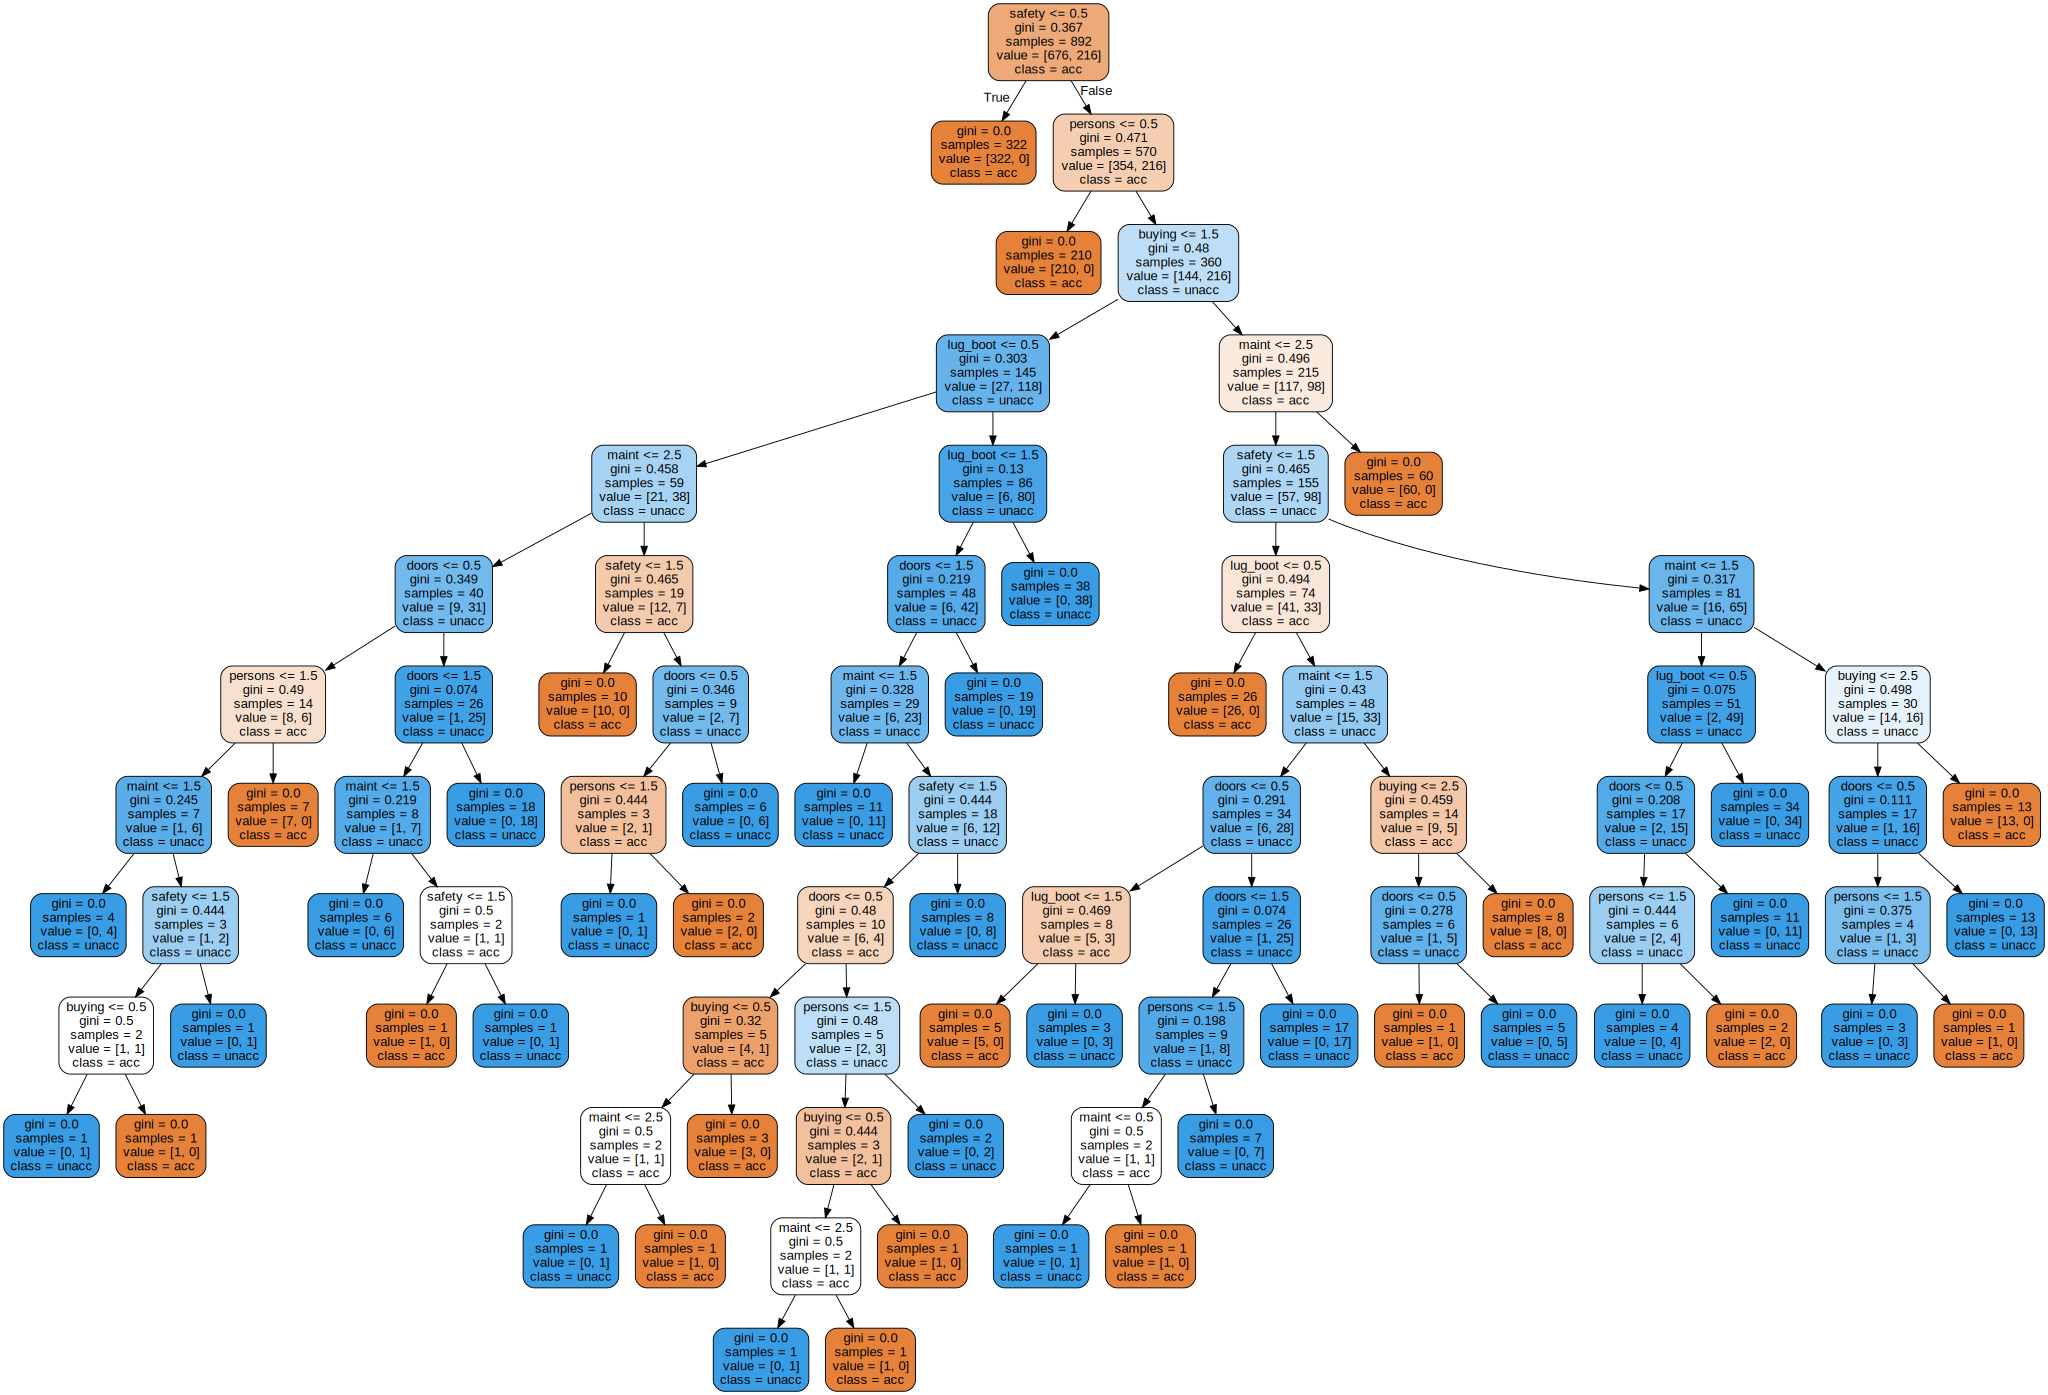

In [28]:
from sklearn import tree
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split

# get the data
train_x,train_y,test_x,test_y=separate_df(train)

start=time.time()
#use parameters to instantiate an algorithm object
clf = tree.DecisionTreeClassifier()
#Training model with training set data
clf = clf.fit(train_x,train_y) 
end=time.time()
print("Time cost for training: "+ str(end-start))

# import the test set to score
result = clf.score(test_x,test_y)

#Predict returns the classification or regression results of each test sample
pre=clf.predict(test_x)

pre=pd.Series(pre)
actual=pd.Series(test_y.tolist())
cor_percentage(pre,actual)

# make a decision table
feature_name = train_x.columns

dot_data = tree.export_graphviz(clf,out_file = None,feature_names= feature_name,class_names=['acc', 'unacc'],filled=True,rounded=True)
graph = graphviz.Source(dot_data)
graph

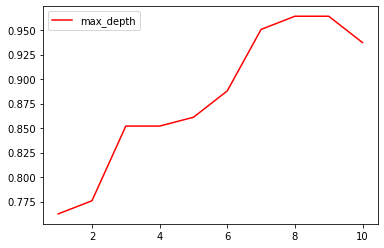

In [29]:
test=[]
# get the data
for i in range(10): 
    clf = tree.DecisionTreeClassifier(max_depth=i+1,criterion="entropy",random_state=30,splitter="random") 
    clf = clf.fit(train_x, train_y) 
    score = clf.score(test_x, test_y) 
    test.append(score) 
# put the score in the graph
plt.plot(range(1,11),test,color="red",label="max_depth") 
plt.legend()
plt.show()

# SVM

In [99]:
from numpy import * 

# choose another random integer other than i
def selectJrand(integer,maximum): 
    tmp=integer
    while (tmp==integer):
        tmp=int(random.uniform(0,maximum))
    return tmp

 # fix the range of a from L to H
def clipAlpha(number,high,low):  
    if number>high:
        number=high
    if low>number:
        number=low
    return number

#kernal transform   x: Feature tree of support vector  data_line: line of data  tup: (type of kernal , varible)
def kernelTrans(fea_tre, data_line, tup): 
    m,n = shape(fea_tre)
    k = mat(zeros((m,1)))
    #linear function
    if tup[0]=='linear': 
        k = fea_tre * data_line.T
    # radial bias function
    elif tup[0]=='rbf': 
        for j in range(m):
            deltaRow = fea_tre[j,:] - data_line
            k[j] = deltaRow*deltaRow.T
        # return the result
        k = exp(k/(-1*tup[1]**2))
    else:
        raise NameError('Kernel is not recognized')
    return k


# define a structure for the covience of data storing
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):
        # attribute
        self.X = dataMatIn
        # label
        self.labelMat = classLabels
        # Punishment of wrong points C
        self.C = C
        self.tol = toler #停止阀值
        # lines of data
        self.m = shape(dataMatIn)[0]
        # make a matrix with zero
        self.alphas = mat(zeros((self.m,1)))
        # default b
        self.b = 0
        # cache
        self.eCache = mat(zeros((self.m,2)))
        # the result of k
        self.K = mat(zeros((self.m,self.m)))
        # calculate the kernel function
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)


def calcEk(oS, k): 
    #Ek = (sum of aj*yj*K(xj,xk))+b-yk
    gXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = gXk - float(oS.labelMat[k])
    return Ek

#update the Os information
def updateEk(oS, k): 
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]


# randomly select aj and return the corresonding E value
def selectJ(i, oS, ei):
    maxK = -1
    maxDE = 0
    ej = 0
    oS.eCache[i] = [1,ei]
    # get the number of line name which is not zero in the matrix
    valid_ecache_list = nonzero(oS.eCache[:,0].A)[0]
    if (len(valid_ecache_list)) > 1:
        for k in valid_ecache_list:
            if k == i:
                continue
            ek = calcEk(oS, k)
            dE = abs(ei - ek)
            
            # return the biggest aj
            if (dE > maxDE):
                maxK = k
                maxDE = dE
                ej = ek
        return maxK, ej
    else:
        j = selectJrand(i, oS.m)
        ej = calcEk(oS, j)
    return j, ej
    

# check if ai satisfied the condition of kkt, if not, randomly choose aj for improve the model, and update the value of ai, aj, b
# input i and the structure which store all the data 
def innerL(i, oS): 
    # calculate the E value
    ei = calcEk(oS, i) 
    if ((oS.labelMat[i]*ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*ei > oS.tol) and (oS.alphas[i] > 0)): 
        # randomly select aj and return the corresonding E value
        j,ej = selectJ(i, oS, ei) 
        alpha_i_old = oS.alphas[i].copy()
        alpha_j_old = oS.alphas[j].copy()
        # the boundary of improvement in two variables
        if (oS.labelMat[i] != oS.labelMat[j]): 
            # when y1 is not equal to y2
            loww = max(0, oS.alphas[j] - oS.alphas[i])
            highh = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            # when y1 equal to y2
            loww = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            highh = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if loww==highh:
            #print("loww==highh")
            return 0
        # get the Eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] 
        if eta >= 0:
            #print("eta>=0")
            return 0
        # get the new alpha
        oS.alphas[j] -= oS.labelMat[j]*(ei - ej)/eta 
        # the solution of alphaj new
        oS.alphas[j] = clipAlpha(oS.alphas[j],highh,loww)
        updateEk(oS, j)
        # the range of the threshold of change size
        if (abs(oS.alphas[j] - alpha_j_old) < oS.tol):
            #print("j not moving enough")
            return 0
        # get the ai new
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alpha_j_old - oS.alphas[j])
        # update the data
        updateEk(oS, i)
        # get the proper number of b
        b1 = oS.b - ei- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.K[i,j]
        b2 = oS.b - ej- oS.labelMat[i]*(oS.alphas[i]-alpha_i_old)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alpha_j_old)*oS.K[j,j]
        # get the different b according to the alphas[i]
        if (0 < oS.alphas[i]<oS.C):
            oS.b = b1
        elif (0 < oS.alphas[j]<oS.C):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0


#Sequential Minimal Optimization,to get the alpha quickly
#Achieved by updating one dimension of the multivariate function each time and iterating for many times until convergence.
# input: Data feature, data labels, parameter C, threshold toler, maximum number of iterations, kernel function
def smoP(data_x, labels, C, toler, maxIter,kTup=('linear', 0)): 
    # new a structural morphology
    oS = optStruct(mat(data_x),mat(labels).transpose(),C,toler, kTup)
    # initial value
    iter = 0
    all_set = True
    alpha_pairs_changed = 0
    print("The model is training for the data...")
    while (iter < maxIter) and ((alpha_pairs_changed > 0) or (all_set)):
        alpha_pairs_changed = 0
        if all_set:
            # went through the whole list
            for i in range(oS.m): 
                alpha_pairs_changed += innerL(i,oS)
                # show the times of the number of iterations, the line of characteristic data that changed the alpha, and the number of alpha changes this time 
                #print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alpha_pairs_changed)) 
            iter += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            #read through the data which is not in the bounduary
            for i in nonBoundIs: 
                alpha_pairs_changed += innerL(i,oS)
                #print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alpha_pairs_changed))
            iter += 1
        if all_set:
            all_set = False
        elif (alpha_pairs_changed == 0):
            all_set = True
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas


def pridict_svm(train_x,train_y,test_x,test_y): # input the data
        
    # get the b and alpha through SMO
    print("start the get the b and alphas")
    b,alphas = smoP(train_x, train_y, 200, 0.0001, 10000, ('rbf', 1.3))

    datMat=mat(train_x)
    labelMat = mat(train_y).transpose()
    # select support vector
    svInd=nonzero(alphas)[0]
    # data of support vector
    sVs=datMat[svInd]
    
    # get the type of support vector(1 or -1)
    labelSV = labelMat[svInd]
    
    # get the shape of test
    datMat_test=mat(test_x)
    m,n = shape(datMat_test)
    
    # predict one by one
    tmp_list=[]
    for i in range(m):
        # transform the support vector into kernal function
        kernelEval = kernelTrans(sVs,datMat_test[i,:],('rbf', 1.3))
        # the pridcition of this line
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        
        # process the data
        transform=array(sign(predict))
        sign_1d=transform.reshape(1)[0]
        tmp_list.append((sign_1d+1)/2)
    
    #transfrom them back to the 1 and 0, then append them to the dataframe
    labelArr_test=(test_y+1)/2
    dataArr_test=test_x.assign(evaluation=labelArr_test)
    pr=dataArr_test.assign(predict=pd.Series(tmp_list).values)
    
    return pr

In [100]:
#input the data for training and for testing
train_x,train_y_10,test_x,test_y_10=separate_df(train)
#preprocess the data to -1 and 1
train_y=2*(train_y_10-0.5)
test_y=2*(test_y_10-0.5)
train_y_reve=-2*(train_y_10-0.5)
test_y_reve=-2*(test_y_10-0.5)
#change them to list
labelMat=train_y.tolist()
dataMat=train_x.values.tolist()
start=time.time()
df=pridict_svm(dataMat,labelMat,test_x,test_y)
end=time.time()
print("Time cost:"+str(end-start))

# predict colounm
pred=df.iloc[:,-1]
# actual colounm
actual=df.iloc[:,-2]
cor_percentage(pred,actual)

start the get the b and alphas


KeyboardInterrupt: 

# Examing and Improving KNN

Since there are many ways to calculate the distance and many K for the using, we can use some method to view their effectiveness. Thus, I rewrite the method and add some other ways to make pridict to the result.

## rewrite the method of knn and add the testing code

In [32]:
# KNN for certain k
def judge_knn_m(train_x,train_y,test_x,test_y,k,method):
    tf=train_x.assign(evaluation=pd.Series(train_y).values)
    finial_list=[]
    test_x_height=test_x.shape[0]
    for i in range(test_x_height):
        
        # sub the i line and take abs for the dataframe
        
        if method==1:
            distance_list=calculate_manhattan(train_x,test_x,i)
        elif method==2:
            distance_list=calculate_Euclidean(train_x,test_x,i)
        else:
            distance_list=calculate_different(train_x,test_x,i)
    
        #store the distance and the result into result df
        result_df=pd.concat([distance_list,tf.iloc[:,-1]],axis=1)
        # change the dataframe to array
        result_list=result_df.values
        
        # return the min distance with it result
        closest=result_list[sorted(np.argsort(result_list.T[0])[:k])]
        counts = np.bincount(closest[0])
        
        #get the counts max result
        type_w = np.argmax(counts)                                       
        
        # put the result for the pridiction line
        finial_list.append(type_w)
    
    pr=test_x.assign(evaluation=pd.Series(test_y).values)
    # insert all the result into the predict dataframe
    pr2 = pr.assign(predict=pd.Series(finial_list).values)
    return pr2

def calculate_manhattan(t,p,i):
    # Manhattan Distance
    abs_subp=abs(t-p.iloc[i])
    # sum by line
    distance_list=abs_subp.sum(axis=1)
    return distance_list

def calculate_Euclidean(t,p,i):
    # euclidean distance
    abs_subp=abs(t*t-p.iloc[i]*p.iloc[i])
    #sum by line
    distance_list=abs_subp.sum(axis=1)
    return distance_list

def calculate_different(t,p,i):
    #different distance
    abs_subp=abs(t-p.iloc[i])
    #sum by line
    distance_list=((abs_subp != 0).astype(int).sum(axis=1))
    return distance_list

In [33]:
def testing(method):# 1: use manhattan to calculate distance  2: use Euclidean to calculate distance 3: use the dirrenece of element as distance
    # set the defalut value
    bestk=1
    best_correctness=0
    times=11
    test_list=[]
    for k in range(1,times):
        k_correctness = 0
        tmp_correctness=[]
        for i in range(10):
            train_x,train_y,test_x,test_y=separate_df(train)
            
            
            # use the judge_knn_m to make the prediction by different method
            df=judge_knn_m(train_x,train_y,test_x,test_y,k,method)
            
            
            # predict colounm
            pred=df.iloc[:,-1]
            # actual colounm
            actual=df.iloc[:,-2]
            
            # put these result to the cor_percentage to get the F-score
            tmp_correctness.append(cor_percentage(pred,actual)[3])
        
        #get the mean of F-score
        s_tmp=sum(tmp_correctness)/(times-1)
        
        # keep record the best one
        if(s_tmp>k_correctness):
            k_correctness=s_tmp
        
        # print the current k and F-score
        print(k)
        print(k_correctness)

        test_list.append(s_tmp)

        # save the best one
        if k_correctness > best_correctness:
            bestk=k
            best_correctness=k_correctness

    #make a graph
    plt.plot(range(1,times),test_list,color="red",label="F-score") 
    plt.legend()
    plt.show()

    print([bestk,best_correctness])

1
0.7324584532385044
2
0.7486221735175159
3
0.7330839401150052
4
0.6933598750283047
5
0.7453498988815784
6
0.744364306798414
7
0.6812539216895617
8
0.6541923554038691
9
0.6755709024193584
10
0.6390505100679553


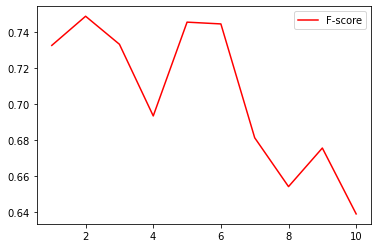

[2, 0.7486221735175159]


In [34]:
#1: use manhattan to calculate distance
testing(1)

1
0.5643719086354261
2
0.5874359958516455
3
0.535923863115026
4
0.5277523095310439
5
0.5380523640036203
6
0.5256576849459192
7
0.5299295878895456
8
0.5420167774494934
9
0.5303633361966585
10
0.5572107530711178


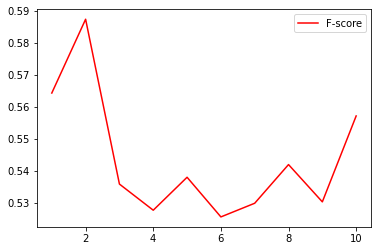

[2, 0.5874359958516455]


In [35]:
#2: use Euclidean to calculate distance 
testing(2)

1
0.6660064895677766
2
0.6545854853299818
3
0.6217451267340257
4
0.6482000710215681
5
0.6207812603623272
6
0.6027816438655245
7
0.637953066171244
8
0.6386718222563769
9
0.5948618503874861
10
0.5934972821753834


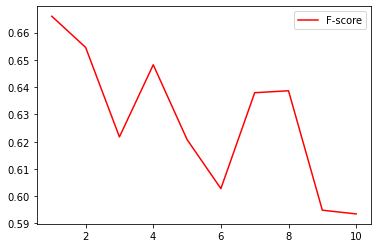

[1, 0.6660064895677766]


In [36]:
#3: use the difference of element as distance
testing(3)

Thus, we can found that the first method is the best, and when k is equal to 4.

# Improvement in preception

   We can use other activate function to replace the step function, and we can have a test for the different learning rate

In [37]:
# ANN
# each funtion update the w for each time, just use a line of data to modify the w
def update_wnew_new(w,I,T,learning_rate):
    #initial value which store the wnew and the sum of weight
    wnew=[]
    
    #get teh sum of weight
    suming=weight_sum_new(w,I)
    
    # return the activate fuction 
    # make the perparation fot the change of w
    O1=activate_func_new(suming)
    
    distance=T-O1
    # make modify for the w
    add_sum=np.array(I)*learning_rate*distance
    tmp=add_sum+np.array(w)
    wnew=tmp.tolist()
    #print(wnew)
    #print(distance,wnew)
    return distance,wnew

def singleANN_new(tf,learning_rate):
    # w_initial=[0,0,0]
    tc=tf.columns
    w=(np.zeros(len(tc))).tolist()
    
    list_I,list_T=transfer_new(tf)
    
    time=0
    
    # if w is changing during the process of reading all the data, it will stay process until it become unchange
    while(1):
        # give a sign when to jump out of the loop
        distance_list=np.empty(shape=0)
        time+=1

        # for every single data in the list_T, check if the w meet the requirement
        for i in range(len(list_T)):
            # for one line
            dis,w=update_wnew_new(w,list_I[i],list_T[i],learning_rate)
        if(time>50):
            break
            
    return w

# return the weight_sum
def weight_sum_new(w,I):
    # get the weight sum
    suming=0
    # sum all the w according to then length of I(w)
    for i in range(len(w)):
        suming+=w[i]*I[i]
    return suming

# return the result of activate function
def activate_func_new(weight_s):
#     #step function
#     if weight_s>=0:
#         return 1
#     else:
#         return 0
    
    # sigmoid update function
    return 1/(1+np.exp(-weight_s))

# return the dataframe according to w
def get_predict_new(w,pred):
    
    df_without=pred.iloc[:,:-1]
    df_label=pred.iloc[:,-1]
    df_without['bias']=np.ones(df_without.shape[0])
    
    # get the output
    mult_df_w=np.array(w)*df_without
    sum_weight=mult_df_w.sum(axis=1)
    
    #use activate to see it
    activate_O=activate_func_new(sum_weight)
    
    result_list=reform_result_new(activate_O)
    
    df_plus=pred.assign(predict=pd.Series(result_list).values)
    return df_plus
    
# change the dataframe into the list_I and list_T
def transfer_new(tf):
    # list_T=[0,0,1,1,0,1]
    # list_I=[[1,5,1],[1,2,1],[1,1,1],[1,3,3],[1,4,2],[1,2,3]]
    
    tc=tf.columns
    list_I=tf[tc[:-1]]
    list_I['bias']=np.ones(tf.shape[0])
    list_I=(list_I.values).tolist()
    list_T=(tf[tc[-1]]).tolist()
    return list_I,list_T

def reform_result_new(activate):#just support the result with 1 and 0
    # change the no constant number to constant
    result_list=[]
    for each in activate:
        if each-0.5>=0:
            result_list.append(1)
        else:
            result_list.append(0)
    return result_list

For different leaning rate, we choose the best one and record it

Total running time: 0.6790497303009033s
(0.8340807174887892, 0.6808510638297872, 0.5925925925925926, 0.6336633663366336)
Total running time: 0.5764496326446533s
(0.8430493273542601, 0.7631578947368421, 0.5272727272727272, 0.6236559139784946)
Total running time: 0.6420469284057617s
(0.852017937219731, 0.6818181818181818, 0.7894736842105263, 0.7317073170731707)
Total running time: 0.6350526809692383s
(0.8340807174887892, 0.6571428571428571, 0.4791666666666667, 0.5542168674698795)
Total running time: 0.5570409297943115s
(0.8385650224215246, 0.7446808510638298, 0.5932203389830508, 0.6603773584905661)
Total running time: 0.5250387191772461s
(0.8295964125560538, 0.7333333333333333, 0.559322033898305, 0.6346153846153846)
Total running time: 0.539039134979248s
(0.8475336322869955, 0.6904761904761905, 0.58, 0.6304347826086957)
Total running time: 0.5420420169830322s
(0.8385650224215246, 0.6363636363636364, 0.5833333333333334, 0.6086956521739131)
Total running time: 0.6130285263061523s
(0.852017

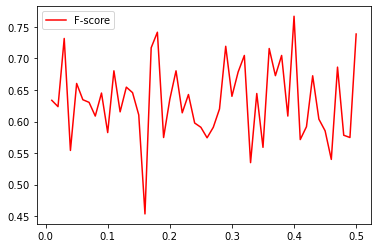

In [49]:
num_list=[]
num=0
besti=0
list_float=np.arange(0.01,0.51,0.01)
list_float=list_float.tolist()
for i in range(len(list_float)):
    # input
    tmp_train,tmp_test=preprocess(tmp_train1, .8,True)
    tf=tmp_train
    pf=tmp_test

    learning_rate=0.01
    start = time.time()
    w=singleANN_new(tf,learning_rate)
    end = time.time()

    print ("Total running time: "+str(end-start)+"s")
    df1=get_predict_new(w,pf)

    # predict colounm
    pred=df1.iloc[:,-1]
    # actual colounm
    actual=df1.iloc[:,-2]

    judge=cor_percentage(pred,actual)
    print(judge)
    if(judge[3]>num):
        num=judge[3]
        besti=list_float[i]
    num_list.append(judge[3])
print(num)
print(besti)
#make a graph
plt.plot(list_float,num_list,color="red",label="F-score") 
plt.legend()
plt.show()

In [50]:
# input
tmp_train,tmp_test=preprocess(tmp_train1, .8,True)
tf=tmp_train
pf=tmp_test

learning_rate=0.5
start = time.time()
w=singleANN_new(tf,learning_rate)
end = time.time()

print ("Total running time: "+str(end-start)+"s")
df1=get_predict_new(w,pf)

# predict colounm
pred=df1.iloc[:,-1]
# actual colounm
actual=df1.iloc[:,-2]
# get the F-score
cor_percentage(pred,actual)

Total running time: 0.6500473022460938s


(0.8251121076233184,
 0.6119402985074627,
 0.7592592592592593,
 0.6776859504132231)

In [29]:
MIX_C  = [[0x02, 0x03, 0x01, 0x01], [0x01, 0x02, 0x03, 0x01], [0x1, 0x1, 0x2, 0x3], [0x3, 0x1, 0x1, 0x2]]
an=[[0xD7,0x30,0xC5,0x77],[0x01,0xF2,0x7B,0xAB],[0x6B,0x63,0x76,0x67],[0x7C,0xFE,0x2B,0x6F]]
# a=D7#01	6B	7C
# b=30#	F2	63	FE
# c=C5#	7B	76	2B
# d=77#	AB	67	6F
for i in an:
    for s in i:
        print(bin(s),end=" ")
    print("\n")

0b11010111 0b110000 0b11000101 0b1110111 

0b1 0b11110010 0b1111011 0b10101011 

0b1101011 0b1100011 0b1110110 0b1100111 

0b1111100 0b11111110 0b101011 0b1101111 



In [1]:
class AES:

    MIX_C  = [[0x2, 0x3, 0x1, 0x1], [0x1, 0x2, 0x3, 0x1], [0x1, 0x1, 0x2, 0x3], [0x3, 0x1, 0x1, 0x2]]
    I_MIXC = [[0xe, 0xb, 0xd, 0x9], [0x9, 0xe, 0xb, 0xd], [0xd, 0x9, 0xe, 0xb], [0xb, 0xd, 0x9, 0xe]]
    RCon   = [0x01000000, 0x02000000, 0x04000000, 0x08000000, 0x10000000, 0x20000000, 0x40000000, 0x80000000, 0x1B000000, 0x36000000]

    S_BOX = [[0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76],
             [0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0],
             [0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15],
             [0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75],
             [0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84],
             [0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF],
             [0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8],
             [0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2],
             [0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73],
             [0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB],
             [0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79],
             [0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08],
             [0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A],
             [0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E],
             [0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF],
             [0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16]]

    I_SBOX = [[0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB],
              [0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB],
              [0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E],
              [0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25],
              [0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92],
              [0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84],
              [0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06],
              [0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B],
              [0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73],
              [0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E],
              [0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B],
              [0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4],
              [0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F],
              [0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF],
              [0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61],
              [0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D]]

    def SubBytes(self, State):
        # 字节替换
        return [self.S_BOX[i][j] for i, j in 
               [(_ >> 4, _ & 0xF) for _ in State]]

    def SubBytes_Inv(self, State):
        # 字节逆替换
        return [self.I_SBOX[i][j] for i, j in
               [(_ >> 4, _ & 0xF) for _ in State]]

    def ShiftRows(self, S):
        # 行移位
        return [S[ 0], S[ 5], S[10], S[15], 
                S[ 4], S[ 9], S[14], S[ 3],
                S[ 8], S[13], S[ 2], S[ 7],
                S[12], S[ 1], S[ 6], S[11]]

    def ShiftRows_Inv(self, S):
        # 逆行移位
        return [S[ 0], S[13], S[10], S[ 7],
                S[ 4], S[ 1], S[14], S[11],
                S[ 8], S[ 5], S[ 2], S[15],
                S[12], S[ 9], S[ 6], S[ 3]]

    def MixColumns(self, State):
        # 列混合
        return self.Matrix_Mul(self.MIX_C, State)

    def MixColumns_Inv(self, State):
        # 逆列混合
        return self.Matrix_Mul(self.I_MIXC, State)

    def RotWord(self, _4byte_block):
        # 用于生成轮密钥的字移位
        return ((_4byte_block & 0xffffff) << 8) + (_4byte_block >> 24)

    def SubWord(self, _4byte_block):
        # 用于生成密钥的字节替换
        result = 0
        for position in range(4):
            i = _4byte_block >> position * 8 + 4 & 0xf
            j = _4byte_block >> position * 8 & 0xf
            result ^= self.S_BOX[i][j] << position * 8
        return result

    def mod(self, poly, mod = 0b100011011):  
        # poly模多项式mod
        while poly.bit_length() > 8:
            poly ^= mod << poly.bit_length() - 9
        return poly

    def mul(self, poly1, poly2):
        # 多项式相乘
        result = 0
        for index in range(poly2.bit_length()):
            if poly2 & 1 << index:
                result ^= poly1 << index
        return result

    def Matrix_Mul(self, M1, M2):  # M1 = MIX_C  M2 = State
        # 用于列混合的矩阵相乘
        M = [0] * 16
        for row in range(4):
            for col in range(4):
                for Round in range(4):
                    M[row + col*4] ^= self.mul(M1[row][Round], M2[Round+col*4])
                M[row + col*4] = self.mod(M[row + col*4])
        return M

    def round_key_generator(self, _16bytes_key):
        # 轮密钥产生
        w = [_16bytes_key >> 96, 
             _16bytes_key >> 64 & 0xFFFFFFFF, 
             _16bytes_key >> 32 & 0xFFFFFFFF, 
             _16bytes_key & 0xFFFFFFFF] + [0]*40
        for i in range(4, 44):
            temp = w[i-1]
            if not i % 4:
                temp = self.SubWord(self.RotWord(temp)) ^ self.RCon[i//4-1]
            w[i] = w[i-4] ^ temp
        return [self.num_2_16bytes(
                    sum([w[4 * i] << 96, w[4*i+1] << 64, 
                         w[4*i+2] << 32, w[4*i+3]])
                    ) for i in range(11)]

    def AddRoundKey(self, State, RoundKeys, index):
        # 异或轮密钥
        return self._16bytes_xor(State, RoundKeys[index])

    def _16bytes_xor(self, _16bytes_1, _16bytes_2):
        return [_16bytes_1[i] ^ _16bytes_2[i] for i in range(16)]

    def _16bytes2num(cls, _16bytes):
        # 16字节转数字
        return int.from_bytes(_16bytes, byteorder = 'big')

    def num_2_16bytes(cls, num):
        # 数字转16字节
        return num.to_bytes(16, byteorder = 'big')

    def aes_encrypt(self, plaintext_list, RoundKeys):
        State = plaintext_list
        State = self.AddRoundKey(State, RoundKeys, 0)
        for Round in range(1,10):
            State = self.SubBytes(State)
            State = self.ShiftRows(State)
            State = self.MixColumns(State)
            #State = self.AddRoundKey(State, RoundKeys, Round)
            break
        #State = self.SubBytes(State)
        #State = self.ShiftRows(State)
        #State = self.AddRoundKey(State, RoundKeys, 10)
        return State

    def aes_decrypt(self, ciphertext_list, RoundKeys):
        State = ciphertext_list
        State = self.AddRoundKey(State, RoundKeys, 10)
        for Round in range(1, 10):
            State = self.ShiftRows_Inv(State)
            State = self.SubBytes_Inv(State)
            State = self.AddRoundKey(State, RoundKeys, 10-Round)
            State = self.MixColumns_Inv(State)
        State = self.ShiftRows_Inv(State)
        State = self.SubBytes_Inv(State)
        State = self.AddRoundKey(State, RoundKeys, 0)
        return State

if __name__ == '__main__':

    aes = AES()
    key = 0x02020202020202020202020202020202
    RoundKeys = aes.round_key_generator(key)

    # 加密
    plaintext = 0x0F0B07030E0A06020D0905010C080400

    # 0x00112233445566778899aabbccddeeff -> b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff'
    plaintext = aes.num_2_16bytes(plaintext)
    ciphertext = aes.aes_encrypt(plaintext, RoundKeys)
    print('ciphertext = ' + hex(aes._16bytes2num(ciphertext)))

    # 解密
    ciphertext = 0x4cdd04ab7886c223c019e500ceb3976e
    ciphertext = aes.num_2_16bytes(ciphertext)
    plaintext = aes.aes_decrypt(ciphertext, RoundKeys)
    print('plaintext = ' + hex(aes._16bytes2num(plaintext)))

    0xD7016B7C30F263FEC57B762B77AB676F


ciphertext = 0x5794ef7989658fa54d666250c7dfd8e3
plaintext = 0xd7016b7c30f263fec57b762b77ab676f


In [65]:
#0b11010111 0b110000 0b11000101 0b1110111
display(bin(3))
hex(0b10010100)

'0b11'

'0x94'